This notebook computes the average SNR a given Voice Dataset. If the SNR is too low, that might reduce the performance or prevent model to learn. SNR paper can be seen here: https://www.cs.cmu.edu/~robust/Papers/KimSternIS08.pdf

To use this notebook, you need:
- WADA SNR estimation: http://www.cs.cmu.edu/~robust/archive/algorithms/WADA_SNR_IS_2008/
    1. extract in the same folder as this notebook
    2. under MacOS you'll have to rebuild the executable. In the build folder: 1) remove existing .o files and 2) run make


- FFMPEG: ```sudo apt-get install ffmpeg ```     


In [19]:
!sudo apt-get install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
!git clone https://github.com/hantswilliams/digitalclone-backend.git
!cd digitalclone-backend/ && git pull

!pip install tts
!tts

Mounted at /content/drive
Cloning into 'digitalclone-backend'...
remote: Enumerating objects: 891, done.
remote: Counting objects: 100% (402/402), done.
remote: Compressing objects: 100% (390/390), done.
remote: Total 891 (delta 60), reused 318 (delta 4), pack-reused 489
Receiving objects: 100% (891/891), 72.91 MiB | 28.67 MiB/s, done.
Resolving deltas: 100% (247/247), done.
Already up to date.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 590 kB 9.7 MB/s 
     |████████████████████████████████| 287 kB 52.2 MB/s 
     |████████████████████████████████| 183 kB 45.5 MB/s 
     |████████████████████████████████| 1.9 MB 58.2 MB/s 
     |████████████████████████████████| 73 kB 2.5 MB/s 
     |████████████████████████████████| 577 kB 46.9 MB/s 
     |████████████████████████████████| 80 kB 9.4 MB/s 
     |████████████████████████████████| 47.4 MB 2.8 MB/s 
     |████████████████████████████████| 3.4 

In [2]:
import os
import glob
import subprocess
import IPython
import soundfile as sf
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
%matplotlib inline

In [3]:
location_metaData = "/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/metaData_list_all.txt"
DATA_PATH = "/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/"
output_path = "/content/drive/MyDrive/VoiceCloning/output"

In [4]:
# Set the meta parameters
# DATA_PATH = "/home/erogol/Data/m-ai-labs/de_DE/by_book/female/eva_k/"
NUM_PROC = 1
CURRENT_PATH = os.getcwd()

In [7]:
!curl http://www.cs.cmu.edu/~robust/archive/algorithms/WADA_SNR_IS_2008/WadaSNR.tar.gz --output WadaSNR.tar.gz
!tar -xvf WadaSNR.tar.gz -C /content/WadaSNR
%cd ..

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2811k  100 2811k    0     0  1261k      0  0:00:02  0:00:02 --:--:-- 1261k
Build/
Build/AudioFile.o
Build/case.o
Build/ckd_alloc.o
Build/SNREst.o
Build/Table.o
Build/Makefile
Build/info.o
Build/Main.o
Build/cmd_ln.o
Build/hash.o
Build/err.o
Build/glist.o
Build/fe_sigproc.o
Build/Config.o
Doc/
Exe/
Exe/WADASNR
Exe/Alpha0.400000.txt
Header/
Header/SNREst.h
Header/Config.h
Header/Debug/
Header/AudioFile.h
Header/Table.h
README
SampleCorrupt/
SampleCorrupt/sb02_Clean.sph
SampleCorrupt/sb01_20dB_Music.sph
SampleCorrupt/sb02_00dB_White.sph
SampleCorrupt/sb01_10dB_Music.sph
SampleCorrupt/sb01_00dB_White.sph
SampleCorrupt/sb01_00dB_Music.sph
SampleCorrupt/sb02_00dB_Music.sph
SampleCorrupt/sb02_10dB_White.sph
SampleCorrupt/sb02_20dB_Music.sph
SampleCorrupt/sb02_10dB_Music.sph
SampleCorrupt/sb01_10dB_White.sph
SampleCorrupt/sb01_Clean.s

In [8]:
def compute_file_snr(file_path):
    """ Convert given file to required format with FFMPEG and process with WADA."""
    _, sr = sf.read(file_path)
    new_file = file_path.replace(".wav", "_tmp.wav")
    if sr != 16000:
        command = f'ffmpeg -i "{file_path}" -ac 1 -acodec pcm_s16le -y -ar 16000 "{new_file}"'
    else:
        command = f'cp "{file_path}" "{new_file}"'
    os.system(command)
    command = [f'"{CURRENT_PATH}/WadaSNR/Exe/WADASNR"', f'-i "{new_file}"', f'-t "{CURRENT_PATH}/WadaSNR/Exe/Alpha0.400000.txt"', '-ifmt mswav']
    output = subprocess.check_output(" ".join(command), shell=True)
    try:
        output = float(output.split()[-3].decode("utf-8"))
    except:
        raise RuntimeError(" ".join(command))
    os.system(f'rm "{new_file}"')
    return output, file_path


In [23]:
wav_file = "/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list200-q1_1671472354686.wav"
output = compute_file_snr(wav_file)
output

(100.0,
 '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list200-q1_1671472354686.wav')

In [10]:
wav_files = glob.glob(f"{DATA_PATH}/**/*.wav", recursive=True)
print(f" > Number of wav files {len(wav_files)}")

 > Number of wav files 262


In [12]:
wav_files

['/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list5-q7_1671048460304.wav',
 '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list3-q9_1671048592548.wav',
 '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list208-q5_1672254048297.wav',
 '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list203-q1_1672254269791.wav',
 '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list208-q8_1672254084620.wav',
 '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list6-q9_1671048409071.wav',
 '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list203-q10_1672254381142.wav',
 '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list219-q9_1672254860946.wav',
 '/content/digitalclone-backe

In [24]:
errors = []
if NUM_PROC == 1:
    file_snrs = [None] * len(wav_files) 
    print(file_snrs)
    for idx, wav_file in tqdm(enumerate(wav_files)):
        try:
          tup = compute_file_snr(wav_file)
          file_snrs[idx] = tup
        except:
          print("something went wrong with: ", wav_file)
          errors.append(['errorWith: ', wav_file])
else:
    with Pool(NUM_PROC) as pool:
        file_snrs = list(tqdm(pool.imap(compute_file_snr, wav_files), total=len(wav_files)))

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

3it [00:00, 19.83it/s]

something went wrong with:  /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list203-q1_1672254269791.wav


34it [00:01, 21.43it/s]

something went wrong with:  /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list15-q1_1671469160632.wav


262it [00:12, 21.51it/s]


In [26]:
file_snrs

[(17.0,
  '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list5-q7_1671048460304.wav'),
 (12.0,
  '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list3-q9_1671048592548.wav'),
 (35.093529,
  '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list208-q5_1672254048297.wav'),
 None,
 (56.89534,
  '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list208-q8_1672254084620.wav'),
 (34.0,
  '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list6-q9_1671048409071.wav'),
 (53.0,
  '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list203-q10_1672254381142.wav'),
 (51.561237,
  '/content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list219-q9_1672254860946.wav'),
 (57.247808,
  '/content/digitalclone-backend/aws_jobs_voice

In [31]:
for i in file_snrs: 
    if i == None: 
        file_snrs.remove(i)
        print('removed None from file_snrs: ', i)


removed None from file_snrs:  None
removed None from file_snrs:  None


In [32]:
snrs = [tup[0] for tup in file_snrs]

error_idxs = np.where(np.isnan(snrs) == True)[0]
error_files = [wav_files[idx] for idx in error_idxs]

file_snrs = [i for j, i in enumerate(file_snrs) if j not in error_idxs]
file_names = [tup[1] for tup in file_snrs]
snrs = [tup[0] for tup in file_snrs]
file_idxs = np.argsort(snrs)


print(f" > Average SNR of the dataset:{np.mean(snrs)}")

 > Average SNR of the dataset:48.85636003461538


In [33]:
def output_snr_with_audio(idx):
    file_idx = file_idxs[idx]
    file_name = file_names[file_idx]
    wav, sr = sf.read(file_name)
    # multi channel to single channel
    if len(wav.shape) == 2:
        wav = wav[:, 0]
    print(f" > {file_name} - snr:{snrs[file_idx]}")
    IPython.display.display(IPython.display.Audio(wav, rate=sr))

In [34]:
# find worse SNR files
N = 10  # number of files to fetch
for i in range(N):
    output_snr_with_audio(i)

 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list4-q10_1671048532914.wav - snr:11.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list5-q4_1671048441252.wav - snr:11.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list3-q9_1671048592548.wav - snr:12.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list6-q6_1671048382963.wav - snr:13.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list9-q2_1671048126153.wav - snr:14.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list7-q3_1671048289013.wav - snr:14.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list7-q9_1671048323379.wav - snr:15.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list200-q8_1671472424628.wav - snr:16.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list7-q8_1671048317827.wav - snr:16.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list6-q5_1671048377678.wav - snr:16.0


In [35]:
# find best recordings
N = 10  # number of files to fetch
for i in range(N):
    output_snr_with_audio(-i-1)

 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list14-q6_1671469119962.wav - snr:100.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list224-q8_1672254228836.wav - snr:100.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list13-q2_1671469036393.wav - snr:100.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list4-q5_1671048508739.wav - snr:100.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list213-q1_1672254939325.wav - snr:100.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list203-q8_1672254364118.wav - snr:100.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list2-q5_1671048628968.wav - snr:100.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list200-q7_1671472420268.wav - snr:100.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list13-q7_1671469063989.wav - snr:100.0


 > /content/digitalclone-backend/aws_jobs_voiceclone/tts_tests/testdata2/clean_quality/wavs/list6-q7_1671048392749.wav - snr:100.0


(array([ 2.,  1.,  1.,  2.,  1.,  5.,  7.,  3.,  1.,  0.,  7.,  9.,  4.,
         7.,  1.,  4.,  8.,  5.,  0.,  8.,  6.,  4.,  8.,  8.,  3.,  4.,
         5.,  1.,  4.,  6.,  4.,  4.,  7.,  1.,  6.,  8.,  1.,  3.,  4.,
         1.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  3.,  1.,  2.,  2.,  2.,
         0.,  3.,  0.,  2.,  0.,  1.,  2.,  1.,  0.,  3.,  3.,  0.,  3.,
         0.,  0.,  0.,  0.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  2.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0., 48.]),
 array([ 11.  ,  11.89,  12.78,  13.67,  14.56,  15.45,  16.34,  17.23,
         18.12,  19.01,  19.9 ,  20.79,  21.68,  22.57,  23.46,  24.35,
         25.24,  26.13,  27.02,  27.91,  28.8 ,  29.69,  30.58,  31.47,
         32.36,  33.25,  34.14,  35.03,  35.92,  36.81,  37.7 ,  38.59,
         39.48,  40.37,  41.26,  42.15,  43.04,  43.93,  44.82,  45.71,
         46.6 ,  47.49,  48.38,  49.27,  50.16,  51.05,  51.94,  52.83,
  

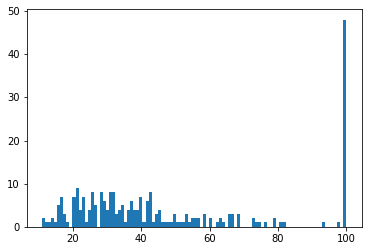

In [36]:
plt.hist(snrs, bins=100)